In [1]:
# Import libraries
import os
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# get data
def setup_data(batch_size: int = 64) -> Tuple[DataLoader, DataLoader, torchvision.datasets.ImageFolder, torchvision.datasets.ImageFolder]:
    """
    Set up data loaders and datasets for training and validation.

    Args:
        batch_size: Number of samples per batch

    Returns:
        train_loader: DataLoader for training
        val_loader: DataLoader for validation
        train_set: Training dataset
        val_set: Validation dataset
    """
    # Download dataset
    path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    data_dir = pathlib.Path(path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Create datasets
    train_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Training'),
        transform=transform
    )
    val_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Testing'),
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f'Training samples: {len(train_set)}')
    print(f'Validation samples: {len(val_set)}')
    print(f'Number of classes: {len(train_set.classes)}')
    print(f'Classes: {train_set.classes}')

    return train_loader, val_loader, train_set, val_set

# Set up data loaders
train_loader, val_loader, train_set, val_set = setup_data(batch_size=64)

Using device: cuda
Training samples: 5712
Validation samples: 1311
Number of classes: 4
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [2]:
# This is the CNN definition
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) # convolution
        self.act1 = nn.Tanh() # activation function
        self.pool1 = nn.MaxPool2d(2) # pooling to reduce size

        # second layer
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # convolution
        self.act2 = nn.Tanh() # activation function
        self.pool2 = nn.MaxPool2d(2) # pooling to reduce size

        # third layer
        self.fc1 = nn.Linear(8 * 32 * 32, 32)
        self.act3 = nn.Tanh()

        # making correct output
        self.fc2 = nn.Linear(32, 4) # 4 outputs for 3 different tumors and 1 non-tumar

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x))) # first layer
        out = self.pool2(self.act2(self.conv2(out))) # second layer
        out = out.view(-1, 8 * 32 * 32) # linearize
        out = self.act3(self.fc1(out)) # last layer
        out = self.fc2(out) # making right output
        return out

model = Net()

# counting the number of parameters
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(263628, [144, 16, 1152, 8, 262144, 32, 128, 4])

In [ ]:
import torch
import torch.nn as nn

# Define a basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = torch.tanh(self.bn1(self.conv1(x)))  # Use Tanh activation
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.tanh(out)  # Use Tanh activation
        return out

# Define the ResNet-like CNN (Res_Net)
class Res_Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()  # Use Tanh activation
        self.pool1 = nn.MaxPool2d(2)
        
        # Residual blocks
        self.resblock1 = ResidualBlock(16, 8, stride=1)  # Match output channels with Net
        self.pool2 = nn.MaxPool2d(2)  # Add pooling to match Net's structure
        
        # Fully connected layers
        self.fc1 = nn.Linear(8 * 32 * 32, 32)  # Match Net's fully connected layer
        self.act3 = nn.Tanh()  # Use Tanh activation
        self.fc2 = nn.Linear(32, 4)  # 4 outputs for 3 tumors + 1 non-tumor

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))  # Initial layer
        out = self.resblock1(out)  # First residual block
        out = self.pool2(out)  # Pooling to match Net's structure
        out = out.view(-1, 8 * 32 * 32)  # Flatten
        #out = out.view(out.size(0), -1)  # Flatten
        out = self.act3(self.fc1(out))  # Fully connected layer 1
        out = self.fc2(out)  # Output layer
        return out

# Instantiate both models

model_resnet = Res_Net()

numel_list_resnet = [p.numel() for p in model_resnet.parameters()]

print("\nRes_Net:")
print(f"Total parameters: {sum(numel_list_resnet)}")
print(f"Parameter breakdown: {numel_list_resnet}")


Res_Net:
Total parameters: 264396
Parameter breakdown: [144, 16, 1152, 8, 8, 8, 576, 8, 8, 8, 128, 8, 8, 8, 262144, 32, 128, 4]


In [3]:
import datetime

# the training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, ben = False):
    # this is to use the GPU?
    model = model.to(device)
    if ben:
      optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
      scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # record training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    # loop over epochs
    for epoch in range(1, n_epochs + 1):
        # Training phase
        model.train()
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        train_correct = 0
        train_total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                val_loss += loss_fn(outputs, labels).item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_loss = loss_train / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_accuracy = 100 * train_correct / train_total
        val_accuracy = 100 * val_correct / val_total


        # Update learning rate
        if ben:
            scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        if epoch == 1 or epoch % 10 == 0:
            print(f'Epoch {epoch}/{n_epochs}:')
            print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')

    return history

In [4]:
model_oulin = Net().to(device) # CNN
optimizer = torch.optim.SGD(model_oulin.parameters(), lr=1e-2) # optimizer
loss_fn = nn.CrossEntropyLoss() # loss function
# training starts here
history_oulin = training_loop(n_epochs = 100, optimizer = optimizer, model = model_oulin, loss_fn = loss_fn, train_loader = train_loader)

Epoch 1/100:
Train Loss: 1.0437, Val Loss: 0.9302, Train Accuracy: 71.36%, Val Accuracy: 64.45%
Epoch 10/100:
Train Loss: 0.4068, Val Loss: 0.5451, Train Accuracy: 84.80%, Val Accuracy: 77.50%
Epoch 20/100:
Train Loss: 0.2673, Val Loss: 0.3906, Train Accuracy: 91.35%, Val Accuracy: 83.83%
Epoch 30/100:
Train Loss: 0.1791, Val Loss: 0.2881, Train Accuracy: 95.31%, Val Accuracy: 88.71%
Epoch 40/100:
Train Loss: 0.1250, Val Loss: 0.4318, Train Accuracy: 85.77%, Val Accuracy: 84.36%
Epoch 50/100:
Train Loss: 0.0836, Val Loss: 0.2123, Train Accuracy: 98.27%, Val Accuracy: 92.83%
Epoch 60/100:
Train Loss: 0.0575, Val Loss: 0.2058, Train Accuracy: 98.46%, Val Accuracy: 93.06%
Epoch 70/100:
Train Loss: 0.0437, Val Loss: 0.1742, Train Accuracy: 99.47%, Val Accuracy: 94.66%
Epoch 80/100:
Train Loss: 0.0315, Val Loss: 0.1901, Train Accuracy: 99.35%, Val Accuracy: 93.67%
Epoch 90/100:
Train Loss: 0.0243, Val Loss: 0.1652, Train Accuracy: 99.81%, Val Accuracy: 95.04%
Epoch 100/100:
Train Loss: 0.01

In [6]:
model_oulin_RN = Res_Net().to(device) # CNN
optimizer = torch.optim.SGD(model_oulin_RN.parameters(), lr=1e-2) # optimizer
loss_fn = nn.CrossEntropyLoss() # loss function
# training starts here
history_oulin_RN = training_loop(n_epochs = 100, optimizer = optimizer, model = model_oulin_RN, loss_fn = loss_fn, train_loader = train_loader)

Epoch 1/100:
Train Loss: 0.7639, Val Loss: 0.6932, Train Accuracy: 80.04%, Val Accuracy: 72.31%
Epoch 10/100:
Train Loss: 0.2246, Val Loss: 0.3470, Train Accuracy: 90.95%, Val Accuracy: 85.74%
Epoch 20/100:
Train Loss: 0.0952, Val Loss: 0.2590, Train Accuracy: 97.25%, Val Accuracy: 90.69%
Epoch 30/100:
Train Loss: 0.0455, Val Loss: 0.1933, Train Accuracy: 99.30%, Val Accuracy: 93.52%
Epoch 40/100:
Train Loss: 0.0260, Val Loss: 0.2161, Train Accuracy: 97.06%, Val Accuracy: 92.14%
Epoch 50/100:
Train Loss: 0.0166, Val Loss: 0.1556, Train Accuracy: 99.91%, Val Accuracy: 94.74%
Epoch 60/100:
Train Loss: 0.0118, Val Loss: 0.1541, Train Accuracy: 99.95%, Val Accuracy: 94.97%
Epoch 70/100:
Train Loss: 0.0089, Val Loss: 0.1588, Train Accuracy: 99.98%, Val Accuracy: 95.42%
Epoch 80/100:
Train Loss: 0.0069, Val Loss: 0.1559, Train Accuracy: 99.98%, Val Accuracy: 95.42%
Epoch 90/100:
Train Loss: 0.0057, Val Loss: 0.1607, Train Accuracy: 100.00%, Val Accuracy: 95.35%
Epoch 100/100:
Train Loss: 0.0

In [8]:
class BrainTumorCNN(nn.Module):
    """
    CNN architecture for brain tumor classification.

    Architecture:
    - 4 convolutional blocks (each with Conv2d, BatchNorm2d, LeakyReLU, MaxPool2d)
    - 2 fully connected layers with dropout
    """
    def __init__(self, num_classes: int = 4):
        super(BrainTumorCNN, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Second conv block
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Third conv block
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Fourth conv block
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),  # Add dropout to prevent overfitting
            nn.Linear(1024, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x



In [24]:
import torch
import torch.nn as nn

# Define a basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        out = torch.tanh(self.bn1(self.conv1(x)))  # Use Tanh activation
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.tanh(out)  # Use Tanh activation
        return out
    
# Define the BrainTumorCNN with ResNet blocks
class BrainTumorCNN_RN(nn.Module):
    """
    CNN architecture for brain tumor classification with ResNet blocks.

    Architecture:
    - 2 convolutional blocks
    - 2 residual blocks
    - 2 fully connected layers with dropout
    """
    def __init__(self, num_classes: int = 4):
        super(BrainTumorCNN_RN, self).__init__()

        # Convolutional and residual layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Second conv block
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # First residual block
            ResidualBlock(32, 64),
            nn.MaxPool2d(2),

            # Second residual block
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*7*7, 1024),  # Adjusted input size
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

In [27]:
# Initialize model
model_ben = BrainTumorCNN().to(device)
print(model_ben)
# counting the number of parameters
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)

history_ben = training_loop(n_epochs = 100, optimizer = optimizer, model = model_ben, loss_fn = loss_fn, train_loader = train_loader, ben = True)

# Initialize model
model_ben_RN = BrainTumorCNN_RN().to(device)
print(model_ben_RN)


history_ben_RN = training_loop(n_epochs = 100, optimizer = optimizer, model = model_ben_RN, loss_fn = loss_fn, train_loader = train_loader, ben = True)


BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

Epoch 1/100:
Train Loss: 0.6984, Val Loss: 0.6356, Train Accuracy: 78.99%, Val Accuracy: 75.36%
Epoch 10/100:
Train Loss: 0.0601, Val Loss: 0.2307, Train Accuracy: 95.76%, Val Accuracy: 92.98%
Epoch 20/100:
Train Loss: 0.0045, Val Loss: 0.0754, Train Accuracy: 100.00%, Val Accuracy: 98.32%
Epoch 30/100:
Train Loss: 0.0003, Val Loss: 0.0777, Train Accuracy: 100.00%, Val Accuracy: 98.78%
Epoch 40/100:
Train Loss: 0.0003, Val Loss: 0.0856, Train Accuracy: 100.00%, Val Accuracy: 98.55%
Epoch 50/100:
Train Loss: 0.0001, Val Loss: 0.0821, Train Accuracy: 100.00%, Val Accuracy: 98.70%
Epoch 60/100:
Train Loss: 0.0001, Val Loss: 0.0871, Train Accuracy: 100.00%, Val Accuracy: 98.47%
Epoch 70/100:
Train Loss: 0.0001, Val Loss: 0.0838, Train Accuracy: 100.00%, Val Accuracy: 98.47%
Epoch 80/100:
Train Loss: 0.0002, Val Loss: 0.0858, Train Accuracy: 100.00%, Val Accuracy: 98.55%
Epoch 90/100:
Train Loss: 0.0001, Val Loss: 0.0847, Train Accuracy: 100.00%, Val Accuracy: 98.63%
Epoch 100/100:
Train Lo

In [ ]:
# Initialize model
model_ben_RN = BrainTumorCNN_RN().to(device)
print(model_ben_RN)


history_ben_RN = training_loop(n_epochs = 100, optimizer = optimizer, model = model_ben_RN, loss_fn = loss_fn, train_loader = train_loader, ben = True)


BrainTumorCNN_RN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ResidualBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0)

Epoch 1/100:
Train Loss: 0.9104, Val Loss: 0.6028, Train Accuracy: 84.26%, Val Accuracy: 76.35%
Epoch 10/100:
Train Loss: 0.1202, Val Loss: 0.8152, Train Accuracy: 82.95%, Val Accuracy: 80.40%
Epoch 20/100:
Train Loss: 0.0620, Val Loss: 0.1203, Train Accuracy: 99.30%, Val Accuracy: 96.26%
Epoch 30/100:
Train Loss: 0.0034, Val Loss: 0.0866, Train Accuracy: 100.00%, Val Accuracy: 97.79%
Epoch 40/100:
Train Loss: 0.0019, Val Loss: 0.1062, Train Accuracy: 100.00%, Val Accuracy: 97.33%
Epoch 50/100:
Train Loss: 0.0017, Val Loss: 0.0853, Train Accuracy: 100.00%, Val Accuracy: 97.79%
Epoch 60/100:
Train Loss: 0.0005, Val Loss: 0.0827, Train Accuracy: 100.00%, Val Accuracy: 97.79%
Epoch 70/100:
Train Loss: 0.0009, Val Loss: 0.0834, Train Accuracy: 100.00%, Val Accuracy: 97.86%
Epoch 80/100:
Train Loss: 0.0004, Val Loss: 0.0836, Train Accuracy: 100.00%, Val Accuracy: 98.02%
Epoch 90/100:
Train Loss: 0.0005, Val Loss: 0.0801, Train Accuracy: 100.00%, Val Accuracy: 97.79%
Epoch 100/100:
Train Los

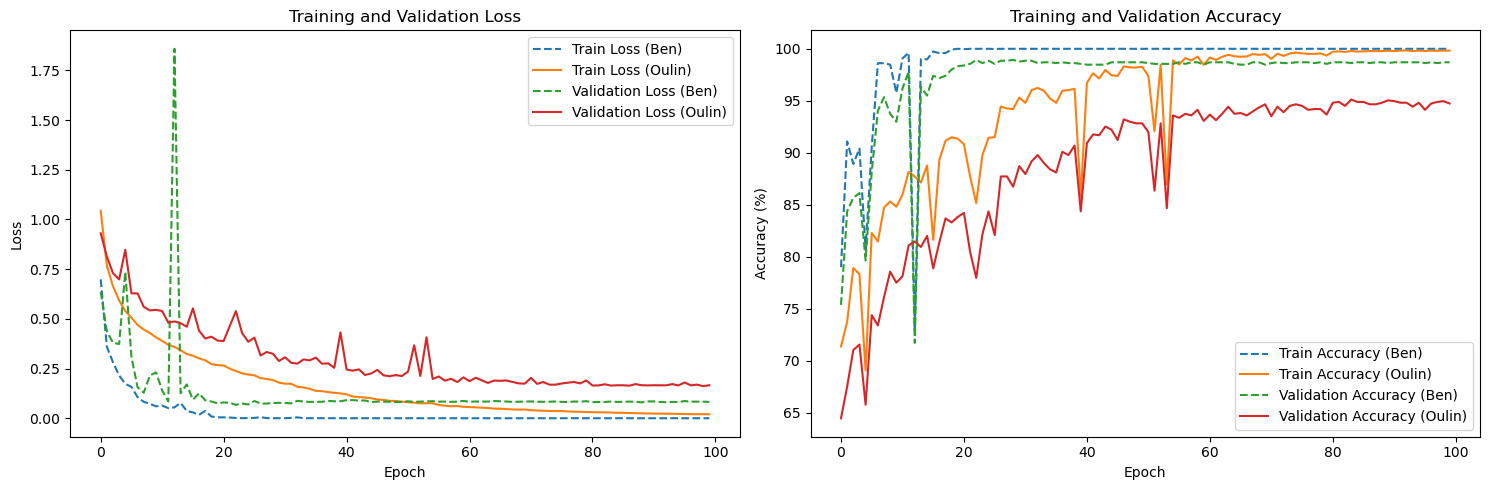

In [28]:
def plot_training_history(history: Dict[str, List[float]], history2: Dict[str, List[float]]):
    """Plot training metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], '--', label='Train Loss (Ben)')
    ax1.plot(history2['train_loss'], label='Train Loss (Oulin)')
    ax1.plot(history['val_loss'], '--', label='Validation Loss (Ben)')
    ax1.plot(history2['val_loss'], label='Validation Loss (Oulin)')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_accuracy'], '--', label='Train Accuracy (Ben)')
    ax2.plot(history2['train_accuracy'], label='Train Accuracy (Oulin)')
    ax2.plot(history['val_accuracy'], '--', label='Validation Accuracy (Ben)')
    ax2.plot(history2['val_accuracy'], label='Validation Accuracy (Oulin)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history_ben, history_oulin)

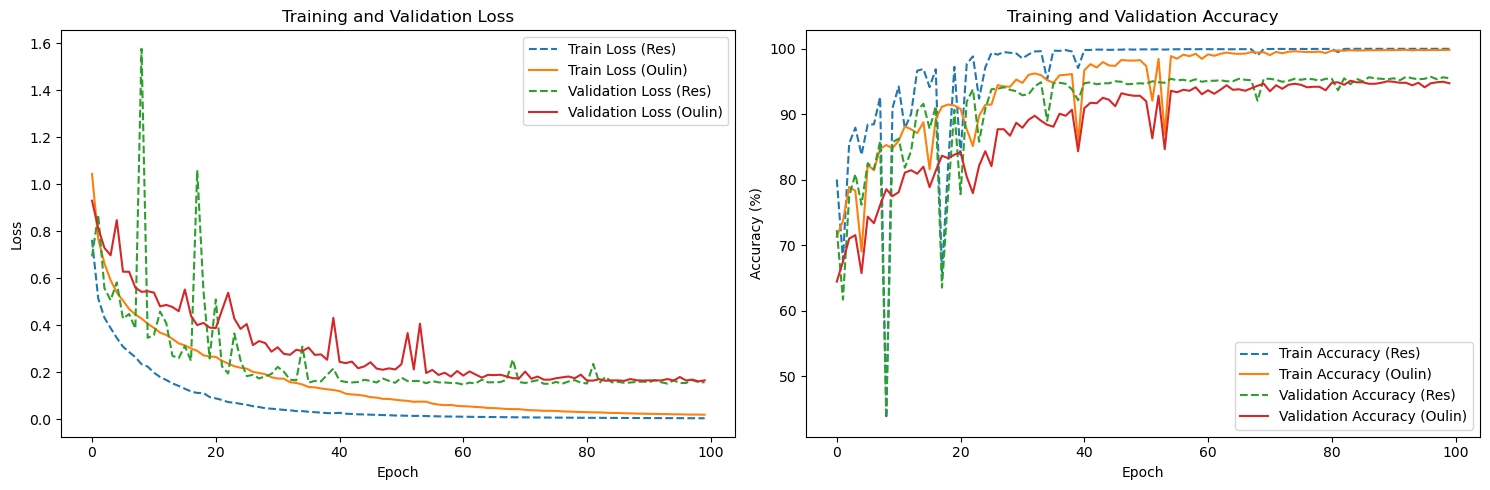

In [29]:
def plot_training_history_res_o(history: Dict[str, List[float]], history2: Dict[str, List[float]]):
    """Plot training metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], '--', label='Train Loss (Res)')
    ax1.plot(history2['train_loss'], label='Train Loss (Oulin)')
    ax1.plot(history['val_loss'], '--', label='Validation Loss (Res)')
    ax1.plot(history2['val_loss'], label='Validation Loss (Oulin)')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_accuracy'], '--', label='Train Accuracy (Res)')
    ax2.plot(history2['train_accuracy'], label='Train Accuracy (Oulin)')
    ax2.plot(history['val_accuracy'], '--', label='Validation Accuracy (Res)')
    ax2.plot(history2['val_accuracy'], label='Validation Accuracy (Oulin)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history_res_o(history_oulin_RN, history_oulin)

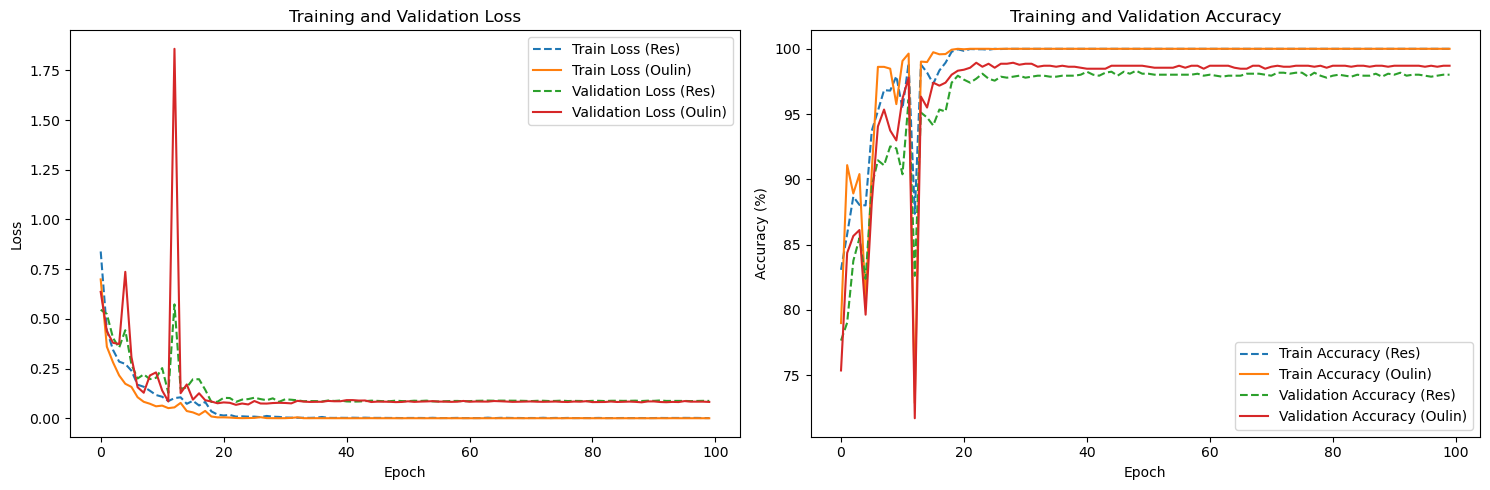

In [30]:
def plot_training_history_res_b(history: Dict[str, List[float]], history2: Dict[str, List[float]]):
    """Plot training metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], '--', label='Train Loss (Res)')
    ax1.plot(history2['train_loss'], label='Train Loss (Ben)')
    ax1.plot(history['val_loss'], '--', label='Validation Loss (Res)')
    ax1.plot(history2['val_loss'], label='Validation Loss (Ben)')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_accuracy'], '--', label='Train Accuracy (Res)')
    ax2.plot(history2['train_accuracy'], label='Train Accuracy (Bem)')
    ax2.plot(history['val_accuracy'], '--', label='Validation Accuracy (Res)')
    ax2.plot(history2['val_accuracy'], label='Validation Accuracy (Ben)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history_res_o(history_ben_RN, history_ben)

In [31]:
def validate(model, train_loader, val_loader):
    for name, loader in [("Training", train_loader), ("Validation", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(device), labels.to(device)
                #print(imgs, labels)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.9f}".format(name , correct / total))

In [32]:
validate(model_ben, train_loader, val_loader) #running the validation

Accuracy Training: 1.000000000
Accuracy Validation: 0.987032799


In [33]:
validate(model_ben_RN, train_loader, val_loader) #running the validation

Accuracy Training: 1.000000000
Accuracy Validation: 0.980167811


In [34]:
validate(model_oulin, train_loader, val_loader) #running the validation

Accuracy Training: 0.998249300
Accuracy Validation: 0.947368421


In [35]:
validate(model_oulin_RN, train_loader, val_loader) #running the validation

Accuracy Training: 1.000000000
Accuracy Validation: 0.954996186
